In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import networkx as nx

from collections import defaultdict

import scipy.sparse as spsparse
import matplotlib.pylab as plt


import pyscisci.all as pyscisci


In [2]:
# set this path to where the DBLP database is stored
path2dblp = '/home/ajgates/DBLP'
path2dblp = '/users/hgt6rn/Documents/DataSets/DBLP'

mymag = pyscisci.DBLP(path2dblp, keep_in_memory=False, show_progress=True) 
# set keep_in_memory=False if you want to load the database each time its needed 
# otherwise keep_in_memory=True will keep each database in memory after its loaded

In [3]:
pubinfo

In [4]:
# First we load all of the publications citing our focus publication
filter_dict = {'CitedPublicationId':np.sort([focus_publication_id])}
citing_focus = mymag.load_references(filter_dict=filter_dict)

focus_citing_pubs = np.sort(citing_focus_df['CitingPublicationId'].unique())

# Then we need all of the publications that cite these publications
pub2ref = mymag.load_references(filter_dict={'CitedPublicationId':focus_citing_pubs})

print("{0} citing publications produce {1} co-cited publications".format(pub2ref_df['CitingPublicationId'].nunique(), 
                                                                         pub2ref_df['CitedPublicationId'].nunique()) )


5778 citing publications produce 234 co-cited publications


In [5]:
# now lets get the field information

finfo = mymag.fieldinfo_df

# we'll take the fields at level 0
lvl0fields = finfo.loc[finfo['FieldLevel'] == 0][['FieldId', 'FieldName']]
fid2name = {fid:fname for fid, fname in lvl0fields.values}


# load the mapping of the publication to the fields

# we filter only for the publications (co-cited publications above)
# and level 0 fields
pub2field = mymag.load_pub2field(filter_dict={'PublicationId':np.sort(pub2ref_df['CitedPublicationId'].unique()), 
                                              'FieldId':np.sort(lvl0fields['FieldId'].unique())})


In [7]:
# we are going to make the co-citation network between all of the publications that cited our focus publication
cocitenet, cocite2int = pyscisci.cocitation_network(pub2ref_df, focus_pub_ids=focus_citing_pubs, 
                                        focus_constraint='cited', 
                                        temporal=False, show_progress=False)

# cocitenet is our network adjcency matrix
# cocite2int maps the publication ids to the row/col of the adjcency matrix
print("{0} nodes, and {1} edges".format(len(cocite2int), cocitenet.nnz))




234 nodes, and 2234 edges


In [8]:
# elminate self-loops
mat = cocitenet.copy()
mat.setdiag(0)

mat.data[mat.data <=1] = 0
mat.eliminate_zeros()

print(mat.nnz)

1036


In [9]:
n_components, labels = spsparse.csgraph.connected_components(mat)
print(n_components)
comidx, compsizes = np.unique(labels, return_counts=True)
print(max(compsizes))

lccidx = np.argmax(compsizes)

lcc = labels==lccidx
lccnodes = np.arange(mat.shape[0])[lcc]
remapnodes = {nid:i for i, nid in enumerate(lccnodes)}
cocite2int = {pid:remapnodes[i] for pid, i in cocite2int.items() if not remapnodes.get(i, None) is None}

lccmat = spsparse.coo_matrix(spsparse.csr_matrix(mat)[lcc][:,lcc])

119
112


In [10]:
cocite_pubs = np.sort(list(cocite2int.keys()))
cocite_fields = pub2field_df.loc[pyscisci.isin_sorted(pub2field_df['PublicationId'].values, cocite_pubs)].copy()

cocite_fields.nunique()

PublicationId    111
FieldId           12
dtype: int64

In [11]:
# most publications are mapped to multiple fields, even at level 1 
# to color our nodes, lets start by seeing which fields appear the most frequently
fieldcount = cocite_fields['FieldId'].value_counts(ascending=False)

for idx in fieldcount.index.values:
    print(idx, fid2name[idx], fieldcount.get(idx))
    
    

41008148 computer science 41
162324750 economics 35
144024400 sociology 20
86803240 biology 3
17744445 political science 3
71924100 medicine 2
15744967 psychology 2
127413603 engineering 2
144133560 business 1
33923547 mathematics 1
121332964 physics 1
39432304 environmental science 1


In [12]:
# we are going to take the largest 3 fields, and group together all of the remaining fields into an "other"
max_fields = 3
reorder_fields = {fid:i for i, fid in enumerate(fieldcount.index.values[:(max_fields+1)])}

cocite_fields['RemappedFields'] = [reorder_fields.get(fid, max_fields) for fid in cocite_fields['FieldId'].values]
cocite_fields.sort_values(by=['RemappedFields'], ascending=True, inplace=True)
cocite_fields.drop_duplicates(subset=['PublicationId'], keep='first', inplace=True)

cocite_fields.reset_index(inplace=True, drop=True)

In [13]:
fieldcount = cocite_fields['RemappedFields'].value_counts(ascending=False)
reorder_fields2 = {i:idx for idx, i in reorder_fields.items()}
for idx in fieldcount.index.values[:(max_fields+1)]:
    if idx < max_fields:
        print(idx, fid2name[reorder_fields2[idx]], fieldcount.get(idx))
        
print(max_fields, "other", fieldcount.get(max_fields))        

0 computer science 41
1 economics 35
2 sociology 20
3 other 15


In [27]:
#field2color = {0:'#DE9E36', 1:'#EF6461',4:'#C287E8',3:'#DFB2F4',2:'#87BFFF'}
field2color = {0:'#E9B44C', 1:'#50A2A7',2:'#8E5572', 3:'#5E8334'}
field2node = defaultdict(list)

for pid, fid in cocite_fields[['PublicationId', 'RemappedFields']].values:
    field2node[fid].append(cocite2int[pid])

# finally, one publication didnt have a field label
field2node[3].append(96)

In [28]:
g = nx.Graph(lccmat)

pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='sfdp')

0 [43, 37, 106, 51, 46, 105, 47, 40, 84, 82, 110, 55, 109, 63, 102, 83, 56, 64, 54, 103, 100, 97, 71, 73, 81, 85, 31, 75, 17, 98, 1, 25, 24, 29, 107, 9, 18, 22, 16, 12, 6] 41
1 [67, 15, 65, 26, 8, 7, 66, 108, 4, 80, 77, 3, 2, 94, 79, 45, 86, 28, 33, 32, 89, 27, 34, 35, 74, 13, 38, 21, 41, 53, 19, 93, 87, 52, 99] 35
2 [88, 91, 57, 72, 14, 10, 20, 23, 30, 42, 76, 44, 68, 60, 101, 59, 70, 78, 48, 95] 20
3 [104, 0, 90, 62, 69, 61, 58, 50, 49, 39, 36, 11, 5, 92, 111, 96] 16


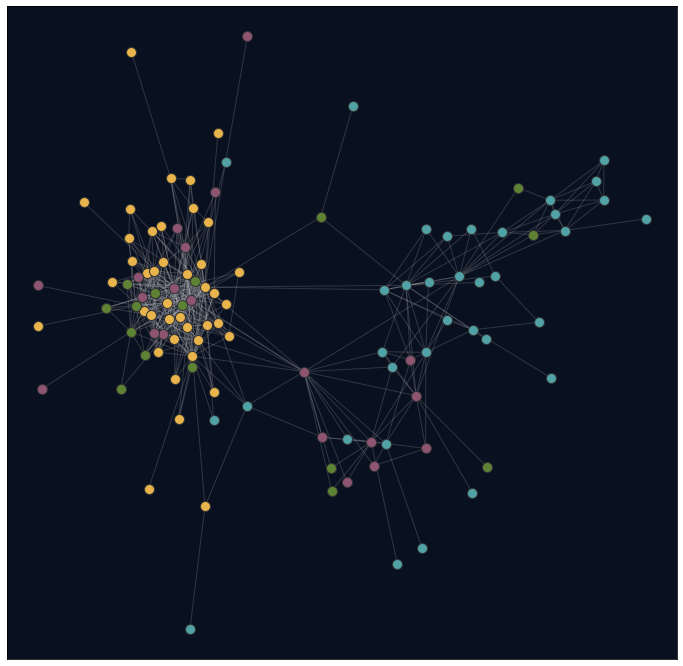

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12,12))         



nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

for fid in field2node.keys():
    nx.draw_networkx_nodes(g.subgraph(field2node[fid]), pos,
        node_size= 100, 
        node_color=field2color[fid], 
        edgecolors='0.2', # node outline
                       vmax = 5,
        ax = ax)
    print(fid, field2node[fid], len(g.subgraph(field2node[fid])))

ax.set_facecolor('#09101F')

#plt.savefig('DiversityCocitiation.pdf')
plt.show()

In [88]:
# we use cdlib to conduct community dectection in networks
# pip install cdlib
from cdlib import algorithms

# and then conduct similarity analysis using clusim
# pip install clusim
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim


coms = algorithms.louvain(g, weight='weight', resolution=1., randomize=False)

louvain_communities = Clustering().from_cluster_list(coms.communities)
field_communities = Clustering(clu2elm_dict = field2node)


print(louvain_communities.n_clusters, field_communities.n_clusters)

print("Element-centric similarity: {}".format(sim.element_sim(louvain_communities, field_communities, alpha = 0.9)) )

elscore, _ = sim.element_sim_elscore(louvain_communities, field_communities, alpha = 0.9)

for c, elist in field2node.items():
    print(c, elscore[elist].mean())

4 4
Element-centric similarity: 0.44567274283666786
0 0.5705767607874603
1 0.516127195064072
2 0.25796838820094636
3 0.20611752588496768


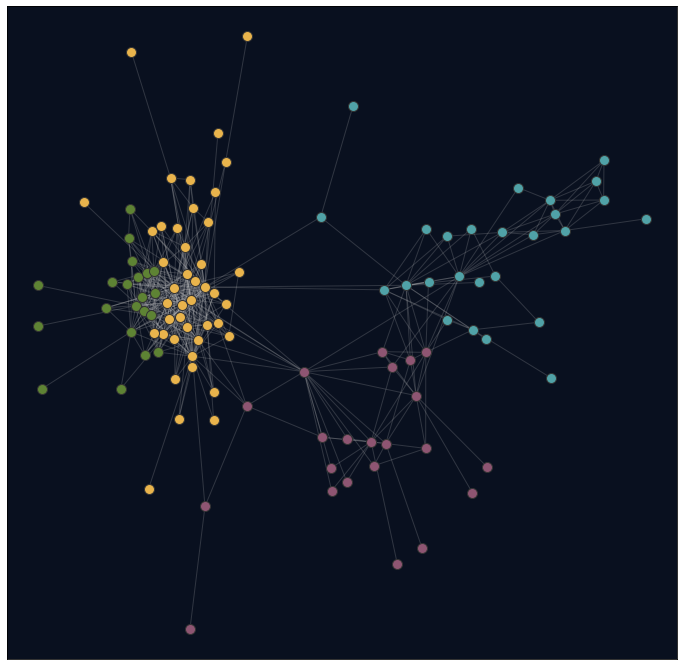

In [72]:
# draw the louvain clusters

fig, ax = plt.subplots(1,1,figsize=(12,12))         

nx.draw_networkx_edges(g, pos, edgelist=g.edges(),
        edge_color = '0.8',
        alpha=0.2,
        ax=ax)

for c in louvain_communities.clusters:
    nx.draw_networkx_nodes(g.subgraph(louvain_communities.clu2elm_dict[c]), pos,
        node_size= 100, 
        node_color=field2color[c], 
        edgecolors='0.2', # node outline
                       vmax = 5,
        ax = ax)
    #print(fid, field2node[c], len(g.subgraph(field2node[c])))

ax.set_facecolor('#09101F')

#plt.savefig('DiversityCocitiation.pdf')
plt.show()

In [73]:
def estimate_resolution(G, com):
    """
    Newman, MEJ (2016) Community detection in networks: Modularity optimization and maximum likelihood are equivalent. Phy. Rev. E
    """
    m = G.number_of_edges()
    
    # eq 16
    kappas = [sum(deg for n, deg in G.degree(c)) for c in com.communities]
    m_in = [G.subgraph(c).number_of_edges() for c in com.communities]
    
    denom = np.sum(np.square(kappas)) / (2*m)
    
    # eq 17
    omega_in = 2*sum(m_in) / denom
    
    # eq 18
    omega_out = (2*m - 2*sum(m_in)) / (2*m - denom)
    
    # eq 15
    gamma = (omega_in - omega_out) / (np.log(omega_in) - np.log(omega_out))
    
    return gamma

estimate_resolution(g, coms)

1.0137403368935076

In [70]:
coms = algorithms.louvain(g, weight='weight', resolution=1.013, randomize=False)
estimate_resolution(g, coms)

1.0137403368935076